# Exploratory Analysis of Document Lengths
 
This notebook provides a comprehensive exploratory analysis of the lengths of cleaned parliamentary documents. The main objectives are to understand the distribution of document lengths, justify the selection of batch sizes, and define filtering criteria for downstream processing and modeling. The analysis is based on the cleaned dataset, and all steps are documented for transparency and reproducibility.

**Key steps in this notebook:**
- **Data Loading and Cleaning:** Load the cleaned JSON data, remove empty texts, and compute character and token lengths for each document.
- **Descriptive Statistics:** Summarize the overall and per-parliament statistics, including boundary counts and deciles for token lengths.
- **Visualization:** Use histograms, boxplots, violinplots, and KDE plots to visualize the distribution of token lengths globally and by parliament. Both overlaid and faceted plots are included for detailed comparison.
- **Cumulative and Non-Cumulative Distributions:** Analyze cumulative coverage at various token thresholds and visualize non-cumulative distributions with global reference lines.
- **Segment Generation and Filtering:** Based on the analysis, define and apply rules to filter documents and split them into segments suitable for annotation and model training. Remove documents and segments that are too short or too long, and summarize the results of the filtering process.

The results of this analysis directly inform the preprocessing pipeline, ensuring that the data used for further tasks is well-understood, consistent, and suitable for the intended modeling approaches.

## 1. Setup and Load Data

Import libraries and use the `process_file` utility to clean the raw JSON and load it into a DataFrame.

In [ ]:
# Import required libraries for data analysis and visualization
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from src.preprocessing import process_file

# Set seaborn theme and color palette for plots
sns.set_theme(style="whitegrid")
palette = sns.color_palette("Set2")
main_color = "skyblue"
line_styles = {
    "BB": (0, (1, 1)),
    "SN": "dotted",
    "TH": "dashed",
    "SA": (0, (5, 1)),
    "MV": (0, (3, 2, 1, 2)),
    "Global": "solid"
}

# Clean the JSON data in memory using the process_file utility
cleaned_data = process_file(
    filepath="01data_collection\combined_transformed_data.json",
    mode="basic",
    file_format="json",
    text_key="ExtrahierterText",
    output_mode="memory"
)

# Load cleaned data into a DataFrame
df = pd.DataFrame(cleaned_data)

# Remove empty texts
df = df[df["ExtrahierterText"].str.strip().astype(bool)]

# Compute character and token lengths for each document
df["CharLength"] = df["ExtrahierterText"].str.len()
df["TokenLength"] = df["ExtrahierterText"].str.split().apply(len)

# Show first rows of the DataFrame
df.head()

<>:23: SyntaxWarning: invalid escape sequence '\c'
<>:23: SyntaxWarning: invalid escape sequence '\c'
C:\Users\tdoro\AppData\Local\Temp\ipykernel_24876\4151914248.py:23: SyntaxWarning: invalid escape sequence '\c'
  filepath="01data_collection\combined_transformed_data.json",


,ID,Landtag,Datum,Beschreibungstext,FilterDetails,Links,ExtrahierterText,CharLength,TokenLength
0,BB_1,BB,16.05.2023,,"[biogas, biomethan]","[{'label': 'Gesamtdokument', 'url': 'https://w...",gesamtdokument: landtag brandenburg drucksache...,5094,656
1,SN_13,SN,16.05.2023,Ausgaben für Sachverständige im Staatsminister...,[leag],[{'label': 'KlAnfr André Barth AfD 16.05.2023 ...,klanfr andré barth afd 16.05.2023 drs 7/13439:...,3678,458
2,SN_14,SN,16.05.2023,Nachfrage zur Drs. 7/13007 Die berufliche Bild...,[kraftwerke],[{'label': 'KlAnfr Timo Schreyer AfD 16.05.202...,klanfr timo schreyer afd 16.05.2023 drs 7/1345...,2642,327
3,SN_15,SN,16.05.2023,Nachfrage zur Drs. 7/13007 Die berufliche Bild...,[kraftwerke],[{'label': 'KlAnfr Frank Peschel AfD 16.05.202...,klanfr frank peschel afd 16.05.2023 drs 7/1345...,2156,281
4,SN_16,SN,16.05.2023,Nachfrage zur Drs. 7/13007 Die berufliche Bild...,[kraftwerke],[{'label': 'KlAnfr Thomas Thumm AfD 16.05.2023...,klanfr thomas thumm afd 16.05.2023 drs 7/13458...,2452,312


## 2. Descriptive Statistics

Overall and by parliament; boundary counts; deciles.

In [2]:
# Print overall statistics for token lengths
print("Overall TokenLength stats:\n", df["TokenLength"].describe())

# Print statistics for token lengths grouped by parliament
print("\nBy Parliament:\n", df.groupby("Landtag")["TokenLength"].describe())

# Print counts for documents below certain thresholds and above the upper threshold
print(f"\n<10 tokens: {(df['TokenLength']<10).sum()}")
print(f"<20 tokens: {(df['TokenLength']<20).sum()}")
print(f">15000 tokens: {(df['TokenLength']>15000).sum()}\n")

# Print deciles for token length distribution
print("Deciles of TokenLength:\n", df["TokenLength"].quantile([i/10 for i in range(11)]))

Overall TokenLength stats:
 count      4177.000000
mean       2289.905195
std        6816.703205
min           1.000000
25%         314.000000
50%         749.000000
75%        1533.000000
max      212581.000000
Name: TokenLength, dtype: float64

By Parliament:
           count         mean          std    min     25%     50%      75%  \
Landtag                                                                     
BB        703.0  3828.820768  6744.668558    1.0  611.00  1122.0  3448.50   
MV        337.0  3060.534125  6543.139968  121.0  502.00   902.0  1730.00   
SA        870.0  2618.243678  4109.576043    1.0  565.50  1074.0  2816.25   
SN       1717.0  1434.760629  8409.701117    3.0  216.00   402.0   897.00   
TH        550.0  2000.940000  3918.867140  104.0  485.25   896.0  1448.75   

              max  
Landtag            
BB        69186.0  
MV        43482.0  
SA        44436.0  
SN       212581.0  
TH        43952.0  

<10 tokens: 135
<20 tokens: 148
>15000 tokens: 131

Deci

## 3. Global Histogram

Plot histogram of token lengths (0–15000).

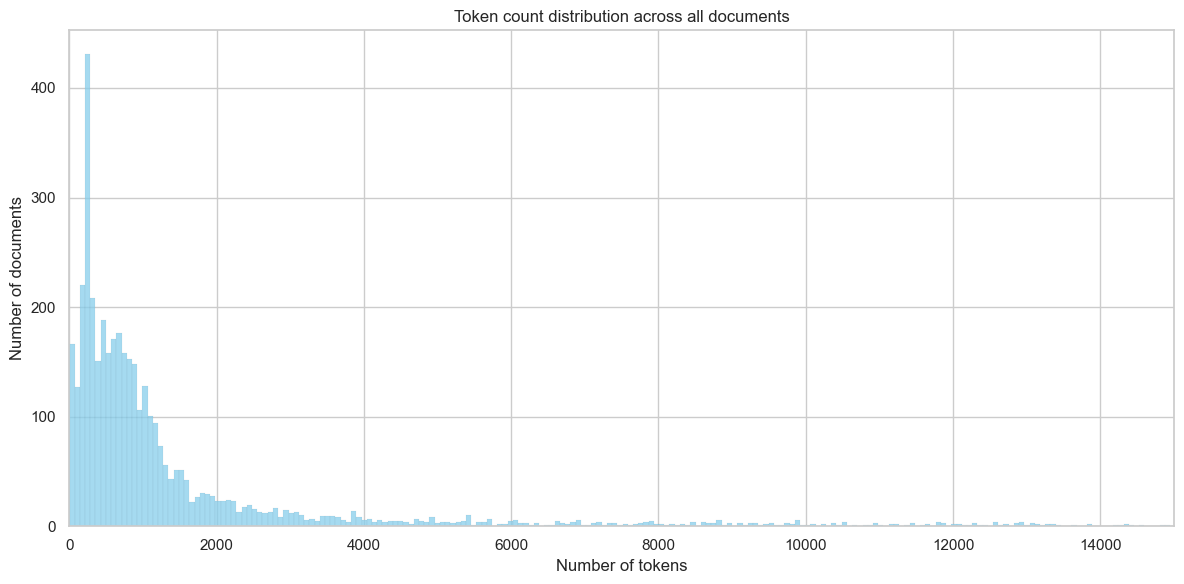

In [3]:
# Plot a histogram of token lengths for all documents (0–15,000 tokens)
plt.figure(figsize=(12,6))
sns.histplot(df["TokenLength"], bins=3000, color=main_color, edgecolor="black")
plt.xlim(0,15000)
plt.title("Token count distribution across all documents")
plt.xlabel("Number of tokens")
plt.ylabel("Number of documents")
plt.tight_layout()
plt.show()

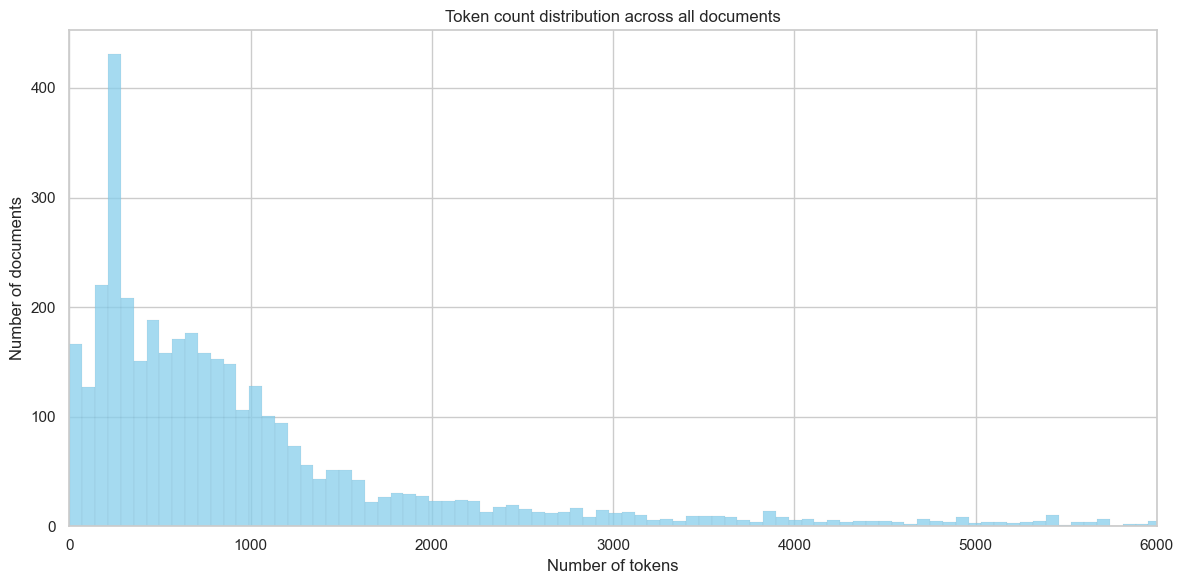

In [4]:
# Plot a zoomed-in histogram of token lengths (0–6,000 tokens)
plt.figure(figsize=(12,6))
sns.histplot(df["TokenLength"], bins=3000, color=main_color, edgecolor="black")
plt.xlim(0,6000)
plt.title("Token count distribution across all documents")
plt.xlabel("Number of tokens")
plt.ylabel("Number of documents")
plt.tight_layout()
plt.show()

## 4. Overlaid Histogram by Parliament

Overlay histograms without normalization.

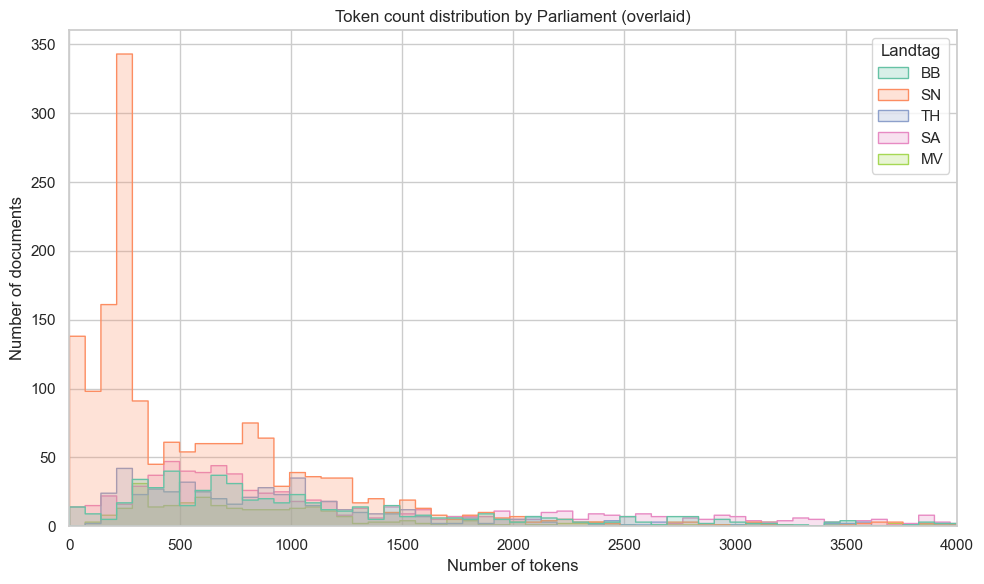

In [5]:
# Plot overlaid histograms of token lengths by parliament (0–4,000 tokens)
plt.figure(figsize=(10,6))
n_colors = df["Landtag"].nunique()
ax = sns.histplot(
    data=df, 
    x="TokenLength", 
    hue="Landtag", bins=3000,
    element="step", 
    stat="count", 
    common_norm=False,
    palette=palette[:n_colors]
)
plt.xlim(0,4000)
plt.title("Token count distribution by Parliament (overlaid)")
plt.xlabel("Number of tokens")
plt.ylabel("Number of documents")
plt.tight_layout()
plt.show()

## 5. Faceted Histograms by Parliament

Facets with uniform axes.

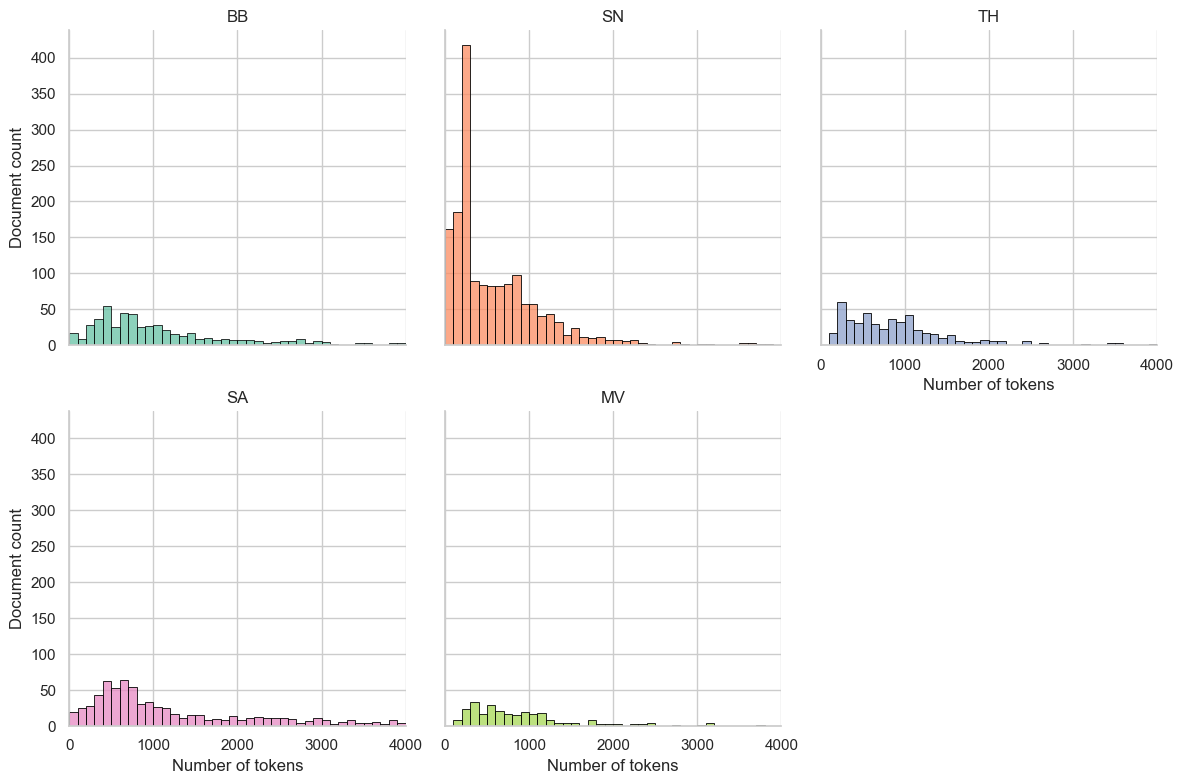

In [6]:
# Plot faceted histograms for each parliament with consistent colors
landtags = df["Landtag"].unique()
color_map = {land: palette[i] for i, land in enumerate(landtags)}
bins = np.arange(0, 4001, 100)

g = sns.FacetGrid(df, col="Landtag", col_wrap=3,
                  height=4, sharex=True, sharey=True)

for ax, land in zip(g.axes.flatten(), landtags):
    subset = df[df["Landtag"] == land]
    sns.histplot(
        subset["TokenLength"],
        bins=bins,
        color=color_map[land],
        edgecolor="black",
        ax=ax
    )
    ax.set_xlim(0, 4000)

g.set_titles(col_template="{col_name}")
g.set_axis_labels("Number of tokens", "Document count")
plt.tight_layout()
plt.show()

## 6. Boxplot by Parliament

Boxplot (0–8000 tokens).

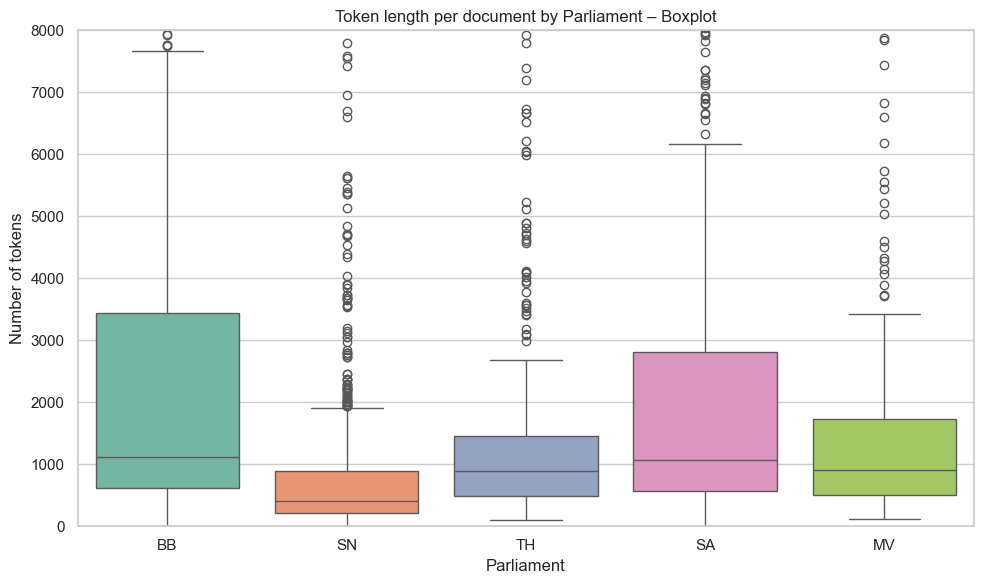

In [7]:
# Plot a boxplot of token lengths per parliament (0–8,000 tokens)
plt.figure(figsize=(10,6))
sns.boxplot(
    data=df, 
    x="Landtag", 
    y="TokenLength", 
    hue="Landtag",
    palette=palette[:n_colors], 
    showfliers=True, 
    dodge=False
)
plt.ylim(0,8000)
plt.title("Token length per document by Parliament – Boxplot")
plt.xlabel("Parliament")
plt.ylabel("Number of tokens")
plt.tight_layout()
plt.show()

## 7. Violinplot by Parliament

Violinplot (0–10000 tokens).

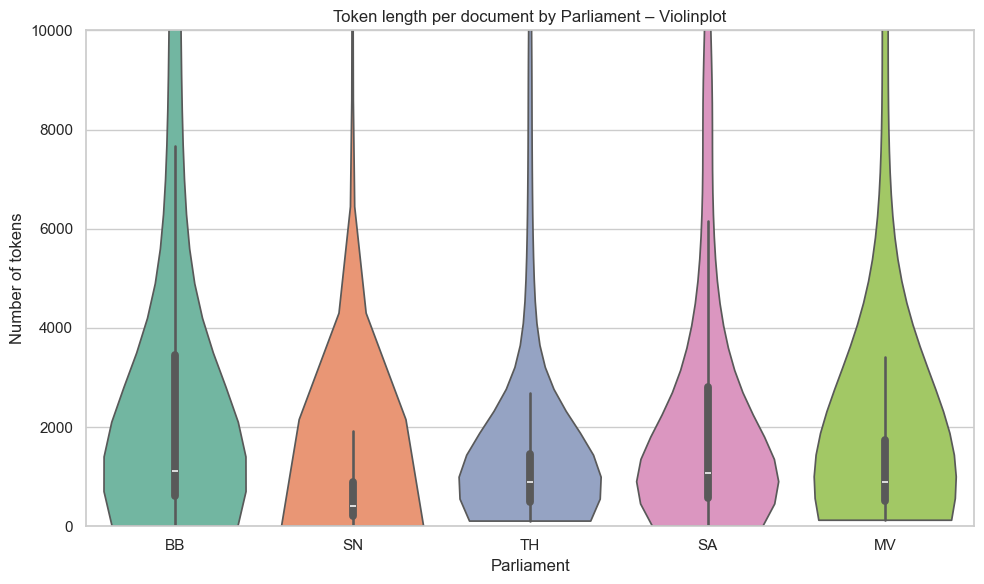

In [8]:
# Plot a violinplot of token lengths per parliament (0–10,000 tokens)
plt.figure(figsize=(10,6))
ax = sns.violinplot(
    data=df, 
    x="Landtag", 
    y="TokenLength", 
    hue="Landtag",
    palette=palette[:n_colors], 
    inner="box", 
    cut=0, 
    dodge=False, 
    legend=False
)
if ax.get_legend():
    ax.get_legend().remove()
plt.ylim(0,10000)
plt.title("Token length per document by Parliament – Violinplot")
plt.xlabel("Parliament")
plt.ylabel("Number of tokens")
plt.tight_layout()
plt.show()

## 8. KDE Plot by Parliament (incl. Global)

KDE with line styles.

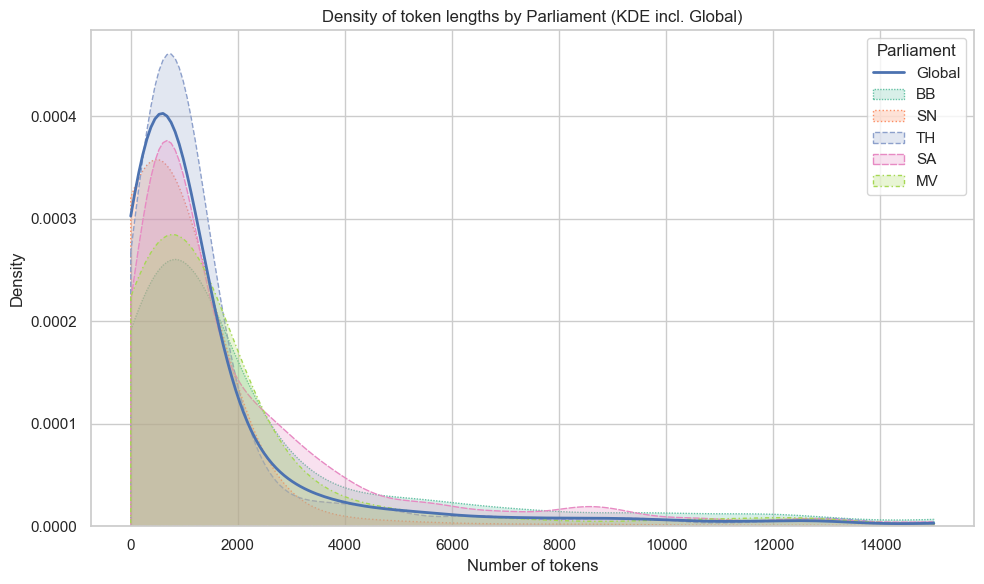

In [9]:
# Plot KDE (Kernel Density Estimate) for token lengths by parliament and global
plt.figure(figsize=(10,6))
sns.kdeplot(df["TokenLength"], 
            fill=False, 
            bw_adjust=0.5, 
            clip=(0,15000),
            label="Global", 
            linestyle=line_styles["Global"], 
            linewidth=2)
for i, land in enumerate(df["Landtag"].unique()):
    subset=df[df["Landtag"]==land]["TokenLength"]
    sns.kdeplot(subset, 
                fill=True, 
                bw_adjust=0.5, 
                clip=(0,15000),
                label=land, 
                linestyle=line_styles[land], 
                color=palette[i])
plt.title("Density of token lengths by Parliament (KDE incl. Global)")
plt.xlabel("Number of tokens")
plt.ylabel("Density")
plt.legend(title="Parliament")
plt.tight_layout()
plt.show()

## 9. Cumulative Curves by Parliament

Plot cumulative coverage at thresholds 1000–15000.

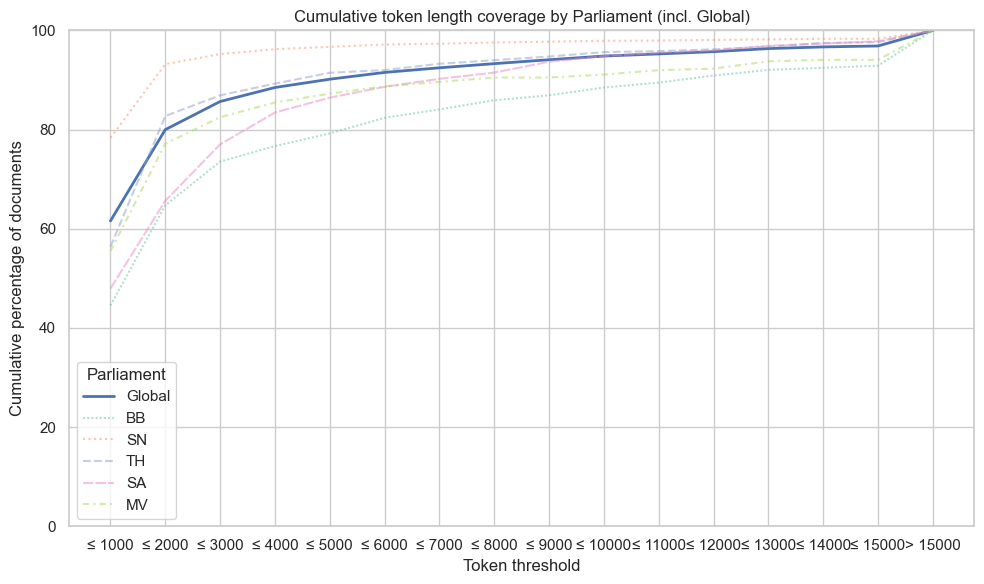

In [10]:
# Plot cumulative coverage curves for token length thresholds by parliament and global
thresholds=list(range(1000,16000,1000))
labels=[f"≤ {t}" for t in thresholds]+["> 15000"]
global_cumsum=[(df["TokenLength"]<=t).mean()*100 for t in thresholds]+[100]

plt.figure(figsize=(10,6))
plt.plot(labels, 
         global_cumsum, 
         label="Global", 
         linestyle=line_styles["Global"], 
         linewidth=2)
for i, land in enumerate(df["Landtag"].unique()):
    sub=df[df["Landtag"]==land]["TokenLength"]
    vals=[(sub<=t).mean()*100 for t in thresholds]+[100]
    plt.plot(labels, 
             vals, 
             label=land, 
             linestyle=line_styles[land], 
             color=palette[i], 
             alpha=0.5)
plt.ylim(0,100)
plt.title("Cumulative token length coverage by Parliament (incl. Global)")
plt.xlabel("Token threshold")
plt.ylabel("Cumulative percentage of documents")
plt.legend(title="Parliament")
plt.tight_layout()
plt.show()

## 10. Non-Cumulative Distribution with Global Line

Bar + global line for token bins.

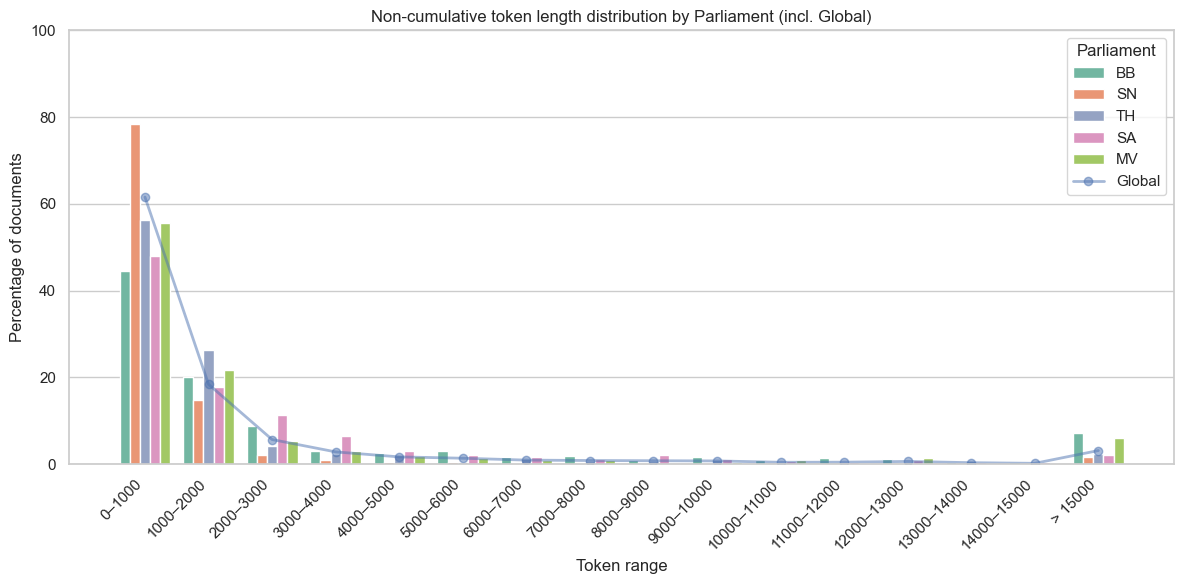

In [11]:

# Plot non-cumulative distribution of token lengths by parliament with global line
bin_edges=list(range(0,16000,1000))+[np.inf]
bin_labels=[f"{s}–{e}" for s,e in zip(bin_edges[:-2], bin_edges[1:-1])] + ["> 15000"]
df["TokenBin"] = pd.cut(df["TokenLength"], bins=bin_edges, labels=bin_labels)

# Calculate percentage per bin for each parliament and globally
bin_percent=(df.groupby("Landtag")["TokenBin"].value_counts(normalize=True).mul(100).rename("Percentage").reset_index())
global_counts = df["TokenBin"].value_counts(normalize=True).sort_index().mul(100)

#for consitent colors across plots
landtags_order = sorted(bin_percent["Landtag"].unique(), key=lambda x: list(df["Landtag"].unique()).index(x))
palette_ordered = [color_map[land] for land in landtags_order]

# Plot non-cumulative distribution of token lengths by parliament with global line
plt.figure(figsize=(12,6))
sns.barplot(data=bin_percent, 
            x="TokenBin", 
            y="Percentage", 
            hue="Landtag", 
            palette=palette_ordered,
            hue_order=landtags_order
            )
plt.plot(bin_labels, global_counts.values, label="Global", linestyle=line_styles["Global"], linewidth=2, marker="o", alpha=0.5)
plt.xticks(rotation=45, ha="right")
plt.ylim(0,100)
plt.title("Non-cumulative token length distribution by Parliament (incl. Global)")
plt.xlabel("Token range")
plt.ylabel("Percentage of documents")
plt.legend(title="Parliament")
plt.tight_layout()
plt.show()

## 11. Segment Generation and Final Filtering


Based on the exploratory analysis, the following decisions were made:


- Remove all documents with more than 15,000 tokens (whitespace tokenization)


- Remove all documents with fewer than 10 tokens


- Split documents into segments of up to 1,000 tokens to limit the context window for labeling and ensure equal document sizes for model training


- After segmenting: remove all segments with fewer than 30 tokens due to low content value

- Some descriptive statistics on segmented data

In [12]:
# Set parameters for batch generation and filtering
MAX_TOKENS = 15000
MIN_TOKENS = 10
SEGMENT_SIZE = 1000
MIN_SEGMENT_TOKENS = 30

# Initialize counters and batch list
removed_empty = 0
removed_too_short = 0
removed_too_long = 0
kept_docs = 0
segments = []

# Iterate through all documents and apply filtering and batching
for entry in cleaned_data:
    # Get and clean the text for the current document
    text = entry.get("ExtrahierterText", "").strip()
    if not text:
        # Skip and count documents with empty text
        removed_empty += 1
        continue
    #white space tokenization
    tokens = text.split()
    token_count = len(tokens)
    if token_count <= MIN_TOKENS:
        # Skip and count documents that are too short
        removed_too_short += 1
        continue
    elif token_count > MAX_TOKENS:
        # Skip and count documents that are too long
        removed_too_long += 1
        continue
    # Document passes all filters and will be kept
    kept_docs += 1
    # Calculate how many segments are needed for this document
    num_segments = (token_count + SEGMENT_SIZE - 1) // SEGMENT_SIZE
    for i in range(num_segments):
        # Determine the start and end indices for the current batch
        start = i * SEGMENT_SIZE
        end = min(start + SEGMENT_SIZE, token_count)
        segment_tokens = tokens[start:end]
        # Create a batch dictionary with relevant metadata and batch text
        segments.append({
            "ID": entry["ID"],
            "BatchID": f"{entry['ID']}_{i+1}",
            "Landtag": entry["Landtag"],
            "Datum": entry["Datum"],
            "Beschreibungstext": entry.get("Beschreibungstext", ""),
            "FilterDetails": entry.get("FilterDetails", []),
            "Links": entry.get("Links", []),
            "SegmentText": " ".join(segment_tokens),
            "SegmentTokenLength": len(segment_tokens)
        })

# Compute totals for reporting
total_docs = len(cleaned_data)
total_segments = len(segments)
average_segments = total_segments / kept_docs if kept_docs else 0

# Filter out segments with too few tokens
filtered = [b for b in segments if len(b["SegmentText"].split()) >= MIN_SEGMENT_TOKENS]
removed_small = total_segments - len(filtered)

# Print summary statistics
print("===== Summary =====")
print(f"Total original documents: {total_docs}")
print(f"Removed (empty): {removed_empty}")
print(f"Removed (≤ {MIN_TOKENS} tokens): {removed_too_short}")
print(f"Removed (> {MAX_TOKENS} tokens): {removed_too_long}")
print(f"Remaining valid documents: {kept_docs}")
print(f"Total segments generated: {total_segments}")
print(f"Average segments per document: {average_segments:.2f}")
print(f"Removed (TokenLength < {MIN_SEGMENT_TOKENS}): {removed_small}")
print(f"Remaining segments: {len(filtered)}")

===== Summary =====
Total original documents: 4647
Removed (empty): 470
Removed (≤ 10 tokens): 139
Removed (> 15000 tokens): 131
Remaining valid documents: 3907
Total segments generated: 8086
Average segments per document: 2.07
Removed (TokenLength < 30): 92
Remaining segments: 7994


In [13]:
# Create a DataFrame from the filtered batches and show info
df_segmented = pd.DataFrame(filtered)
df_segmented.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7994 entries, 0 to 7993
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   ID                  7994 non-null   object
 1   BatchID             7994 non-null   object
 2   Landtag             7994 non-null   object
 3   Datum               7994 non-null   object
 4   Beschreibungstext   7994 non-null   object
 5   FilterDetails       7994 non-null   object
 6   Links               7994 non-null   object
 7   SegmentText         7994 non-null   object
 8   SegmentTokenLength  7994 non-null   int64 
dtypes: int64(1), object(8)
memory usage: 562.2+ KB


In [15]:
# Print overall statistics for token lengths
print("Overall SegmentTokenLength stats:\n", df_segmented["SegmentTokenLength"].describe())

# Print statistics for token lengths grouped by parliament
print("\nBy Parliament:\n", df_segmented.groupby("Landtag")["SegmentTokenLength"].describe())

Overall SegmentTokenLength stats:
 count    7994.000000
mean      744.614211
std       325.952764
min        30.000000
25%       455.000000
50%      1000.000000
75%      1000.000000
max      1000.000000
Name: SegmentTokenLength, dtype: float64

By Parliament:
           count        mean         std   min     25%     50%     75%     max
Landtag                                                                      
BB       1809.0  835.860144  276.153714  32.0  725.00  1000.0  1000.0  1000.0
MV        670.0  760.038806  314.981507  31.0  502.75  1000.0  1000.0  1000.0
SA       2257.0  823.229065  282.795244  32.0  667.00  1000.0  1000.0  1000.0
SN       2166.0  575.490305  348.496122  30.0  226.25   544.0  1000.0  1000.0
TH       1092.0  756.967949  317.985994  31.0  495.00  1000.0  1000.0  1000.0


## 12. Test new python module `segment_documents` based on exploratory-analysis

In [ ]:
#implemented segment_documents() in src.preprocessing as performed in step 11
from src.preprocessing import process_file, segment_documents

#test
test_data = process_file('01data_collection\combined_transformed_data.json', mode='basic', output_mode='memory')
test_data_segmented = segment_documents(test_data)

df_test = pd.DataFrame(test_data_segmented)
#df_test.info()
df_test.head()

<>:5: SyntaxWarning: invalid escape sequence '\c'
<>:5: SyntaxWarning: invalid escape sequence '\c'
C:\Users\tdoro\AppData\Local\Temp\ipykernel_33384\3551174664.py:5: SyntaxWarning: invalid escape sequence '\c'
  test_data = process_file('01data_collection\combined_transformed_data.json', mode='basic', output_mode='memory')


===== Summary =====
Total original documents: 4647
Removed (empty): 470
Removed (≤ 10 tokens): 139
Removed (> 15000 tokens): 131
Remaining valid documents: 3907
Total batches generated: 8086
Average batches per document: 2.07
Removed (TokenLength < 30): 92
Remaining batches: 7994


,ID,BatchID,Landtag,Datum,Beschreibungstext,FilterDetails,Links,BatchText,BatchTokenLength
0,BB_1,BB_1_1,BB,16.05.2023,,"[biogas, biomethan]","[{'label': 'Gesamtdokument', 'url': 'https://w...",gesamtdokument: landtag brandenburg drucksache...,656
1,SN_13,SN_13_1,SN,16.05.2023,Ausgaben für Sachverständige im Staatsminister...,[leag],[{'label': 'KlAnfr André Barth AfD 16.05.2023 ...,klanfr andré barth afd 16.05.2023 drs 7/13439:...,458
2,SN_14,SN_14_1,SN,16.05.2023,Nachfrage zur Drs. 7/13007 Die berufliche Bild...,[kraftwerke],[{'label': 'KlAnfr Timo Schreyer AfD 16.05.202...,klanfr timo schreyer afd 16.05.2023 drs 7/1345...,327
3,SN_15,SN_15_1,SN,16.05.2023,Nachfrage zur Drs. 7/13007 Die berufliche Bild...,[kraftwerke],[{'label': 'KlAnfr Frank Peschel AfD 16.05.202...,klanfr frank peschel afd 16.05.2023 drs 7/1345...,281
4,SN_16,SN_16_1,SN,16.05.2023,Nachfrage zur Drs. 7/13007 Die berufliche Bild...,[kraftwerke],[{'label': 'KlAnfr Thomas Thumm AfD 16.05.2023...,klanfr thomas thumm afd 16.05.2023 drs 7/13458...,312


#check if in-memory data matches file
from src.io_utils import compare_list_to_json
compare_list_to_json(test_data_batched, "3Final_Basic_Cleaned_BatchedData_Min30.json")